In [1]:
import pyart
import numpy as np
from fix_velocity import driver_fix_velocity

radar = pyart.io.read_cfradial('sample_data/KUNIMI_20240828_140000_EL002_V10.nc')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### plot raw velocity and check velocity in each ray

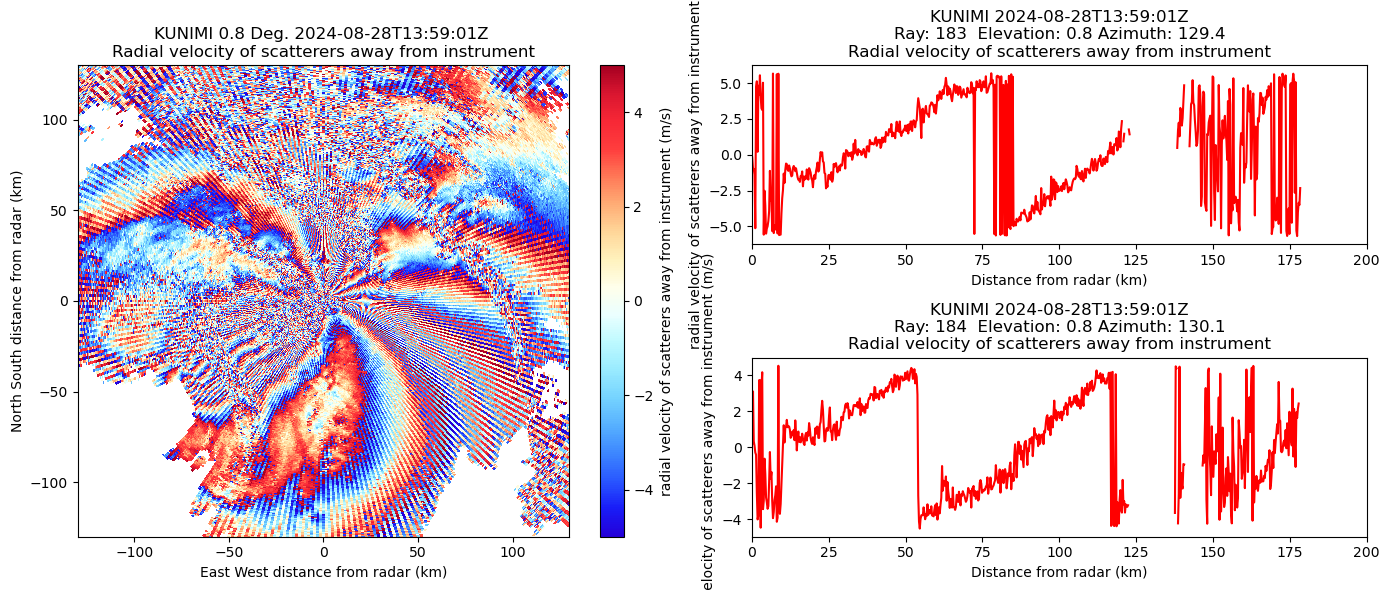

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

display = pyart.graph.RadarDisplay(radar)

## choose sweep and ray
sweep = 0

fig = plt.figure(figsize=(14,6), tight_layout=True)
gs = gridspec.GridSpec(2, 2)

## 2d plot
ax1 = fig.add_subplot(gs[:, 0])
display.set_limits((-130, 130), (-130, 130), ax=ax1)
display.plot_ppi('V', sweep, cmap="BuDRd18", vmin=-5, vmax=5, ax=ax1)

## line plot
ray = 183
ax  = fig.add_subplot(gs[0, 1])
display.set_limits((0, 200),  ax=ax)
display.plot_ray('V', ray, ax=ax, format_str='r-')

ray = 184
ax  = fig.add_subplot(gs[1, 1])
display.set_limits((0, 200),  ax=ax)
display.plot_ray('V', ray, ax=ax, format_str='r-')


### compute dual prf velocity and nyquist velocity in each ray (C-band)

In [3]:
velocity_dualprf, nyquist_velocity_ray = driver_fix_velocity(radar, band='C',)

radar.add_field_like('V', 'V_dualprf', velocity_dualprf)
print(nyquist_velocity_ray[:10])

[4.5595808  5.69947624 4.5595808  5.69947624 4.5595808  5.69947624
 4.5595808  5.69947624 4.5595808  5.69947624]


### plot dualprf velocity

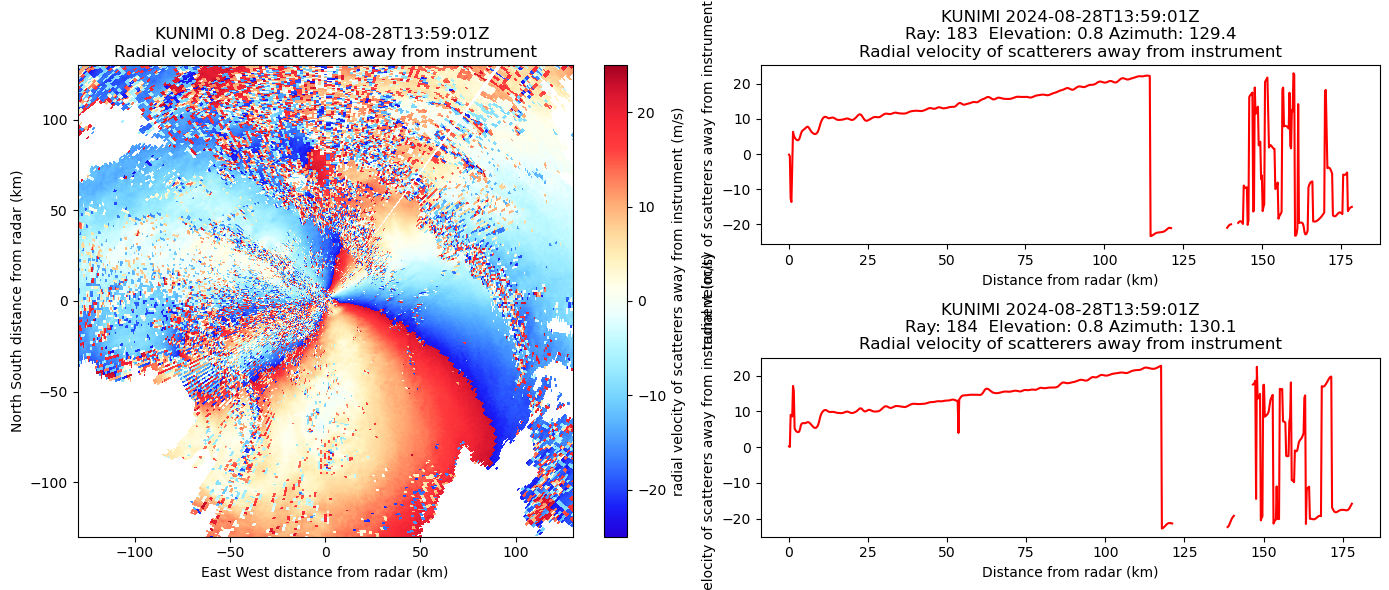

In [4]:
display = pyart.graph.RadarDisplay(radar)

## choose sweep and ray
sweep = 0

fig = plt.figure(figsize=(14,6), tight_layout=True)
gs = gridspec.GridSpec(2, 2)

## 2d plot
ax1 = fig.add_subplot(gs[:, 0])
display.set_limits((-130, 130), (-130, 130), ax=ax1)
display.plot_ppi('V_dualprf', sweep, cmap="BuDRd18", vmin=-25, vmax=25, ax=ax1)

## line plot
display.set_limits((0, 200),  ax=ax)
ray = 183
ax  = fig.add_subplot(gs[0, 1])
display.plot_ray('V_dualprf', ray, ax=ax, format_str='r-')

ray = 184
ax  = fig.add_subplot(gs[1, 1])
display.plot_ray('V_dualprf', ray, ax=ax, format_str='r-')


### extract raw velocity for specific nyquist velocity

In [5]:
nyq_vel_h, nyq_vel_l = np.max(nyquist_velocity_ray), np.min(nyquist_velocity_ray)
vel_raw = radar.fields['V']['data']

vel_raw_h = vel_raw.copy()
vel_raw_l = vel_raw.copy()

vel_raw_h.mask[ nyquist_velocity_ray == nyq_vel_l ] = True
vel_raw_l.mask[ nyquist_velocity_ray == nyq_vel_h ] = True

radar.add_field_like('V', 'V_nyq_vel_h', vel_raw_h)
radar.add_field_like('V', 'V_nyq_vel_l', vel_raw_l)

### plot raw velocity 

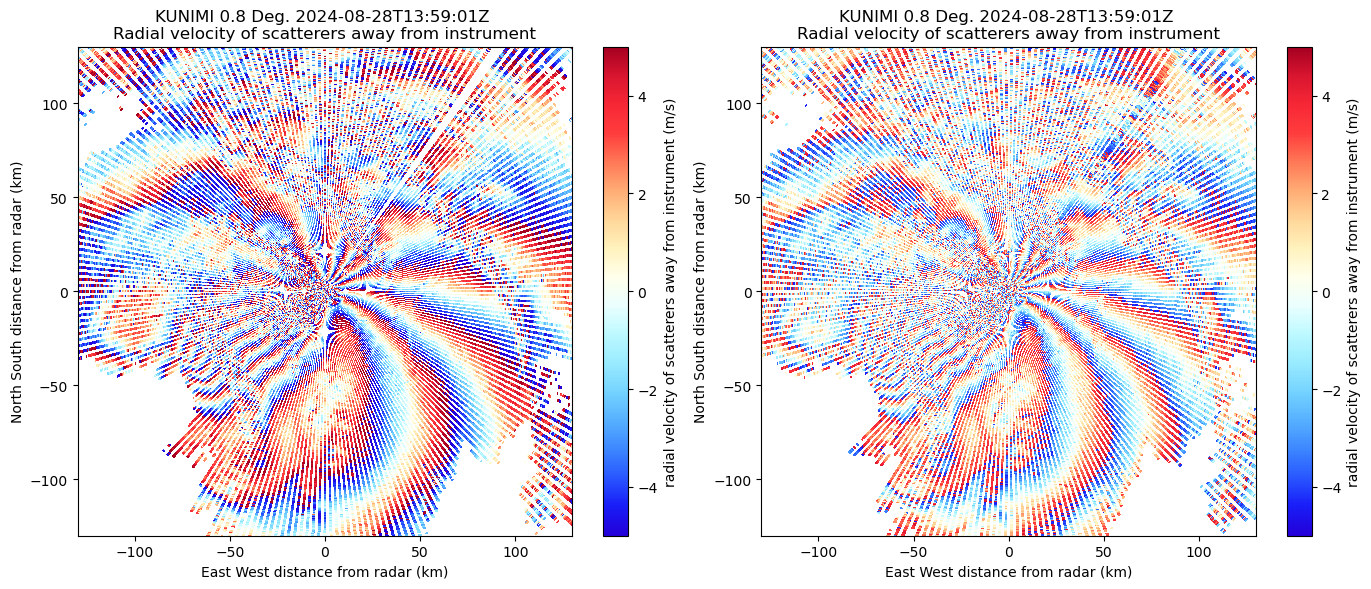

In [6]:
fig = plt.figure(figsize=(14,6), tight_layout=True)
gs = gridspec.GridSpec(1, 2)

## 2d plot
ax1 = fig.add_subplot(gs[0, 0])
display.set_limits((-130, 130), (-130, 130), ax=ax1)
display.plot_ppi('V_nyq_vel_h', sweep, cmap="BuDRd18", vmin=-5, vmax=5, ax=ax1)

ax2 = fig.add_subplot(gs[0, 1])
display.set_limits((-130, 130), (-130, 130), ax=ax2)
display.plot_ppi('V_nyq_vel_l', sweep, cmap="BuDRd18", vmin=-5, vmax=5, ax=ax2)

### Unwrap velocity by scikit-image (but the results are weird)

In [17]:
from fix_velocity import unwrap_velocity_skimage, smooth
#correct_V_nyq_vel_h = pyart.correct.dealias_unwrap_phase(radar, nyquist_vel=nyq_vel_h, vel_field='V_nyq_vel_h', rays_wrap_around=True)
#correct_V_nyq_vel_l = pyart.correct.dealias_unwrap_phase(radar, nyquist_vel=nyq_vel_l, vel_field='V_nyq_vel_l', rays_wrap_around=True)
#correct_V_nyq_vel_h = unwrap_velocity_skimage(radar.fields['V_nyq_vel_h']['data'], nyq_vel_h, radar.iter_slice())
#correct_V_nyq_vel_l = unwrap_velocity_skimage(radar.fields['V_nyq_vel_l']['data'], nyq_vel_l, radar.iter_slice())


### smooth velocity
vel_raw_h_smooth = smooth(vel_raw_h, np.full(vel_raw_h.shape[0], nyq_vel_h))
vel_raw_l_smooth = smooth(vel_raw_l, np.full(vel_raw_l.shape[0], nyq_vel_l))
radar.add_field_like('V', 'V_nyq_vel_h', vel_raw_h_smooth, replace_existing=True)
radar.add_field_like('V', 'V_nyq_vel_l', vel_raw_l_smooth, replace_existing=True)

correct_V_nyq_vel_h = pyart.correct.dealias_region_based(radar, nyquist_vel=nyq_vel_h, vel_field='V_nyq_vel_h', rays_wrap_around=True, interval_splits=4)
correct_V_nyq_vel_l = pyart.correct.dealias_region_based(radar, nyquist_vel=nyq_vel_l, vel_field='V_nyq_vel_l', rays_wrap_around=True, interval_splits=4)

#print(correct_V_nyq_vel_h.max(), correct_V_nyq_vel_h.min())
#print(correct_V_nyq_vel_l.max(), correct_V_nyq_vel_l.min())

#radar.add_field_like('V', 'correct_V_nyq_vel_h', correct_V_nyq_vel_h, replace_existing=True)
#radar.add_field_like('V', 'correct_V_nyq_vel_l', correct_V_nyq_vel_l, replace_existing=True)
radar.add_field('correct_V_nyq_vel_h', correct_V_nyq_vel_h, replace_existing=True)
radar.add_field('correct_V_nyq_vel_l', correct_V_nyq_vel_l, replace_existing=True)

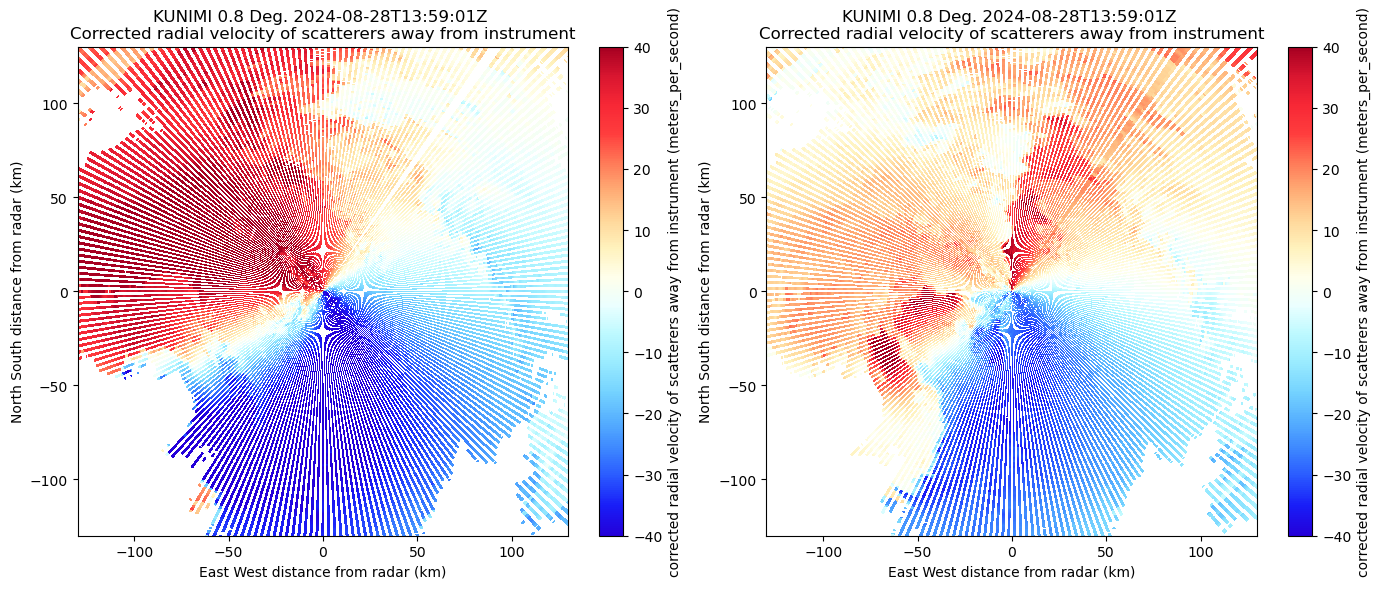

In [18]:
fig = plt.figure(figsize=(14,6), tight_layout=True)
gs = gridspec.GridSpec(1, 2)

## 2d plot
ax1 = fig.add_subplot(gs[0, 0])
display.set_limits((-130, 130), (-130, 130), ax=ax1)
display.plot_ppi('correct_V_nyq_vel_h', sweep, cmap="BuDRd18", vmin=-40, vmax=40, ax=ax1)

ax2 = fig.add_subplot(gs[0, 1])
display.set_limits((-130, 130), (-130, 130), ax=ax2)
display.plot_ppi('correct_V_nyq_vel_l', sweep, cmap="BuDRd18", vmin=-40, vmax=40, ax=ax2)